# Automation of human karyotype analysis using image segmentation and classification methods. Segmentation

# Imports

In [1]:
!gdown 1fUWGsTT9GMmQXt9NGqIcmLgaRyWMbWzg

Downloading...
From (original): https://drive.google.com/uc?id=1fUWGsTT9GMmQXt9NGqIcmLgaRyWMbWzg
From (redirected): https://drive.google.com/uc?id=1fUWGsTT9GMmQXt9NGqIcmLgaRyWMbWzg&confirm=t&uuid=4a0d2d2e-9b36-4c97-9f56-93a244e59392
To: /content/Data.zip
100% 567M/567M [00:11<00:00, 49.9MB/s]


In [2]:
!unzip /content/Data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/24_chromosomes_object/JEPG/1101262.jpg  
  inflating: __MACOSX/Data/24_chromosomes_object/JEPG/._1101262.jpg  
  inflating: Data/24_chromosomes_object/JEPG/1071791.jpg  
  inflating: __MACOSX/Data/24_chromosomes_object/JEPG/._1071791.jpg  
  inflating: Data/24_chromosomes_object/JEPG/1051441.jpg  
  inflating: __MACOSX/Data/24_chromosomes_object/JEPG/._1051441.jpg  
  inflating: Data/24_chromosomes_object/JEPG/1053242.jpg  
  inflating: __MACOSX/Data/24_chromosomes_object/JEPG/._1053242.jpg  
  inflating: Data/24_chromosomes_object/JEPG/1055633.jpg  
  inflating: __MACOSX/Data/24_chromosomes_object/JEPG/._1055633.jpg  
  inflating: Data/24_chromosomes_object/JEPG/1050993.jpg  
  inflating: __MACOSX/Data/24_chromosomes_object/JEPG/._1050993.jpg  
  inflating: Data/24_chromosomes_object/JEPG/1057024.jpg  
  inflating: __MACOSX/Data/24_chromosomes_object/JEPG/._1057024.jpg  
  inflating: Data/24_chromosomes_object/JEPG/1

# Segmentation

## Faster R-CNN and Retinanet

In [3]:
!pip install ultralytics
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 976.9/976.9 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [1]:
import os
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import DataLoader
from PIL import Image
import torchvision
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
import cv2
from ultralytics import YOLO
import glob
import random
import shutil
import numpy as np

In [8]:
def load_dataset(images_dir, annotations_dir):
    dataset = []
    image_files = sorted(os.listdir(images_dir))
    for image_filename in image_files:
        image_path = os.path.join(images_dir, image_filename)
        image = Image.open(image_path).convert("RGB")

        annotation_filename = os.path.splitext(image_filename)[0] + '.xml'
        annotation_path = os.path.join(annotations_dir, annotation_filename)
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            labels.append(1)
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}
        image = F.to_tensor(image)

        dataset.append((image, target))
    return dataset

def get_retinanet_model(num_classes):
    model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
    in_features = model.head.classification_head.conv[0][0].in_channels
    num_anchors = model.head.classification_head.num_anchors
    model.head.classification_head = RetinaNetClassificationHead(in_features, num_anchors, num_classes)
    return model

def get_fasterrcnn_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    running_loss = 0.0
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        running_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    return running_loss / len(data_loader)

def evaluate(model, data_loader, device):
    metric = MeanAveragePrecision(iou_thresholds=[0.5])
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            outputs = [{k: v.cpu() for k, v in out.items()} for out in outputs]
            targets = [{k: v.cpu() for k, v in t.items()} for t in targets]
            metric.update(outputs, targets)
    mAP = metric.compute()
    return mAP

def inference_check(model, dataset, device, index=0, score_threshold=0.5):
    model.eval()
    image, target = dataset[index]
    image_tensor = image.to(device)

    with torch.no_grad():
        output = model([image_tensor])[0]

    image_np = image.mul(255).permute(1, 2, 0).cpu().numpy().astype("uint8")

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(image_np)
    for box in target['boxes']:
        xmin, ymin, xmax, ymax = box.cpu().numpy()
        gt_rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor='g', facecolor='none'
        )
        axes[1].add_patch(gt_rect)
    axes[1].set_title("Ground Truth Boxes")
    axes[1].axis("off")

    axes[2].imshow(image_np)
    for box, score in zip(output['boxes'], output['scores']):
        if score > score_threshold:
            xmin, ymin, xmax, ymax = box.cpu().numpy()
            pred_rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            axes[2].add_patch(pred_rect)
    axes[2].set_title("Predicted Boxes")
    axes[2].axis("off")

    plt.show()


=== Training Faster R-CNN ===
Faster R-CNN Epoch 1/10, Loss: 0.6572
Faster R-CNN Epoch 1/10, mAP@0.5: 0.9597
Faster R-CNN Epoch 2/10, Loss: 0.5126
Faster R-CNN Epoch 2/10, mAP@0.5: 0.9523
Faster R-CNN Epoch 3/10, Loss: 0.4752
Faster R-CNN Epoch 3/10, mAP@0.5: 0.9519
Faster R-CNN Epoch 4/10, Loss: 0.4465
Faster R-CNN Epoch 4/10, mAP@0.5: 0.9629
Faster R-CNN Epoch 5/10, Loss: 0.4259
Faster R-CNN Epoch 5/10, mAP@0.5: 0.9641
Faster R-CNN Epoch 6/10, Loss: 0.4149
Faster R-CNN Epoch 6/10, mAP@0.5: 0.9530
Faster R-CNN Epoch 7/10, Loss: 0.4018
Faster R-CNN Epoch 7/10, mAP@0.5: 0.9552
Faster R-CNN Epoch 8/10, Loss: 0.3906
Faster R-CNN Epoch 8/10, mAP@0.5: 0.9552
Faster R-CNN Epoch 9/10, Loss: 0.3821
Faster R-CNN Epoch 9/10, mAP@0.5: 0.9644
Faster R-CNN Epoch 10/10, Loss: 0.3740
Faster R-CNN Epoch 10/10, mAP@0.5: 0.9558


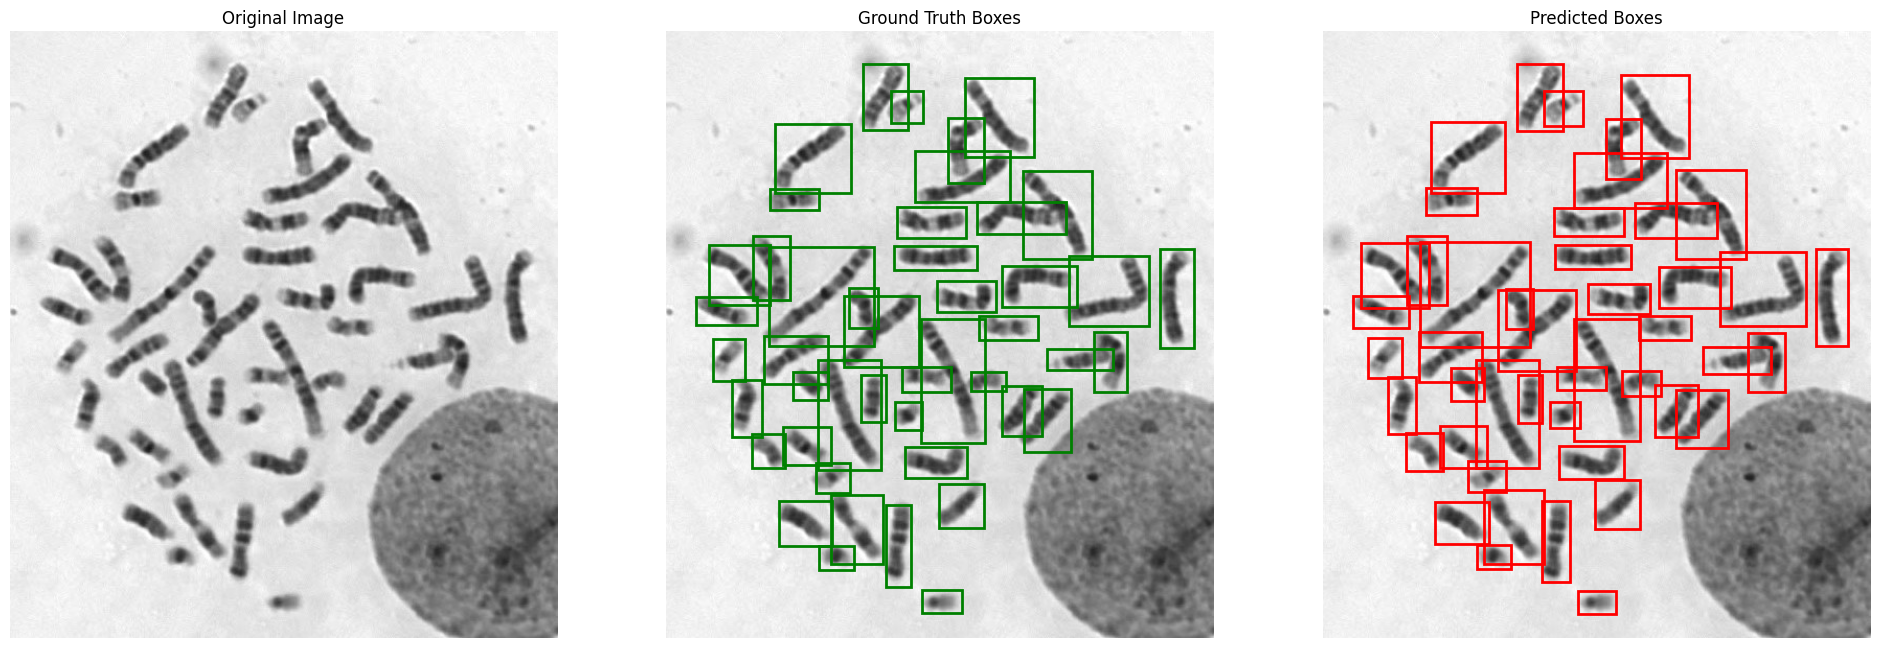


=== Training RetinaNet ===


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 222MB/s]


RetinaNet Epoch 1/10, Loss: 0.6973


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


RetinaNet Epoch 1/10, mAP@0.5: 0.8773
RetinaNet Epoch 2/10, Loss: 0.3262
RetinaNet Epoch 2/10, mAP@0.5: 0.9371
RetinaNet Epoch 3/10, Loss: 0.2789
RetinaNet Epoch 3/10, mAP@0.5: 0.9459
RetinaNet Epoch 4/10, Loss: 0.2626
RetinaNet Epoch 4/10, mAP@0.5: 0.9395
RetinaNet Epoch 5/10, Loss: 0.2517
RetinaNet Epoch 5/10, mAP@0.5: 0.9535
RetinaNet Epoch 6/10, Loss: 0.2428
RetinaNet Epoch 6/10, mAP@0.5: 0.9538
RetinaNet Epoch 7/10, Loss: 0.2341
RetinaNet Epoch 7/10, mAP@0.5: 0.9511
RetinaNet Epoch 8/10, Loss: 0.2291
RetinaNet Epoch 8/10, mAP@0.5: 0.9562
RetinaNet Epoch 9/10, Loss: 0.2200
RetinaNet Epoch 9/10, mAP@0.5: 0.9568
RetinaNet Epoch 10/10, Loss: 0.2148
RetinaNet Epoch 10/10, mAP@0.5: 0.9567


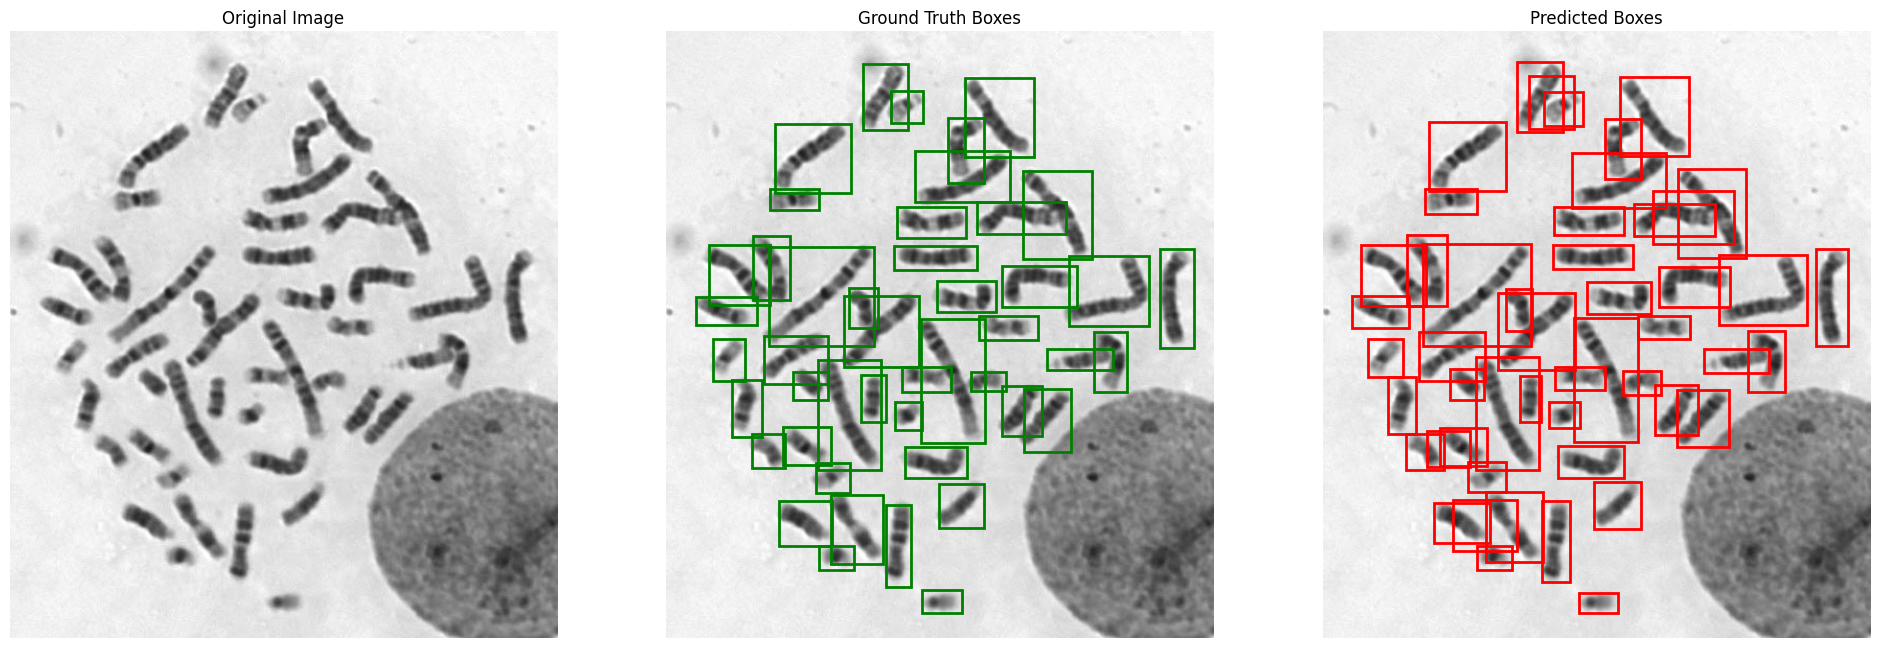

In [9]:
images_dir = "/content/Data/single_chromosomes_object/JEPG"
annotations_dir = "/content/Data/single_chromosomes_object/anntations"

full_dataset = load_dataset(images_dir, annotations_dir)

indices = list(range(len(full_dataset)))
split = int(0.8 * len(full_dataset))
train_dataset = [full_dataset[i] for i in indices[:split]]
val_dataset = [full_dataset[i] for i in indices[split:]]

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_classes = 2
num_epochs = 10

models_dict = {
    "Faster R-CNN": get_fasterrcnn_model,
    "RetinaNet": get_retinanet_model
}

for model_name, model_func in models_dict.items():
    print(f"\n=== Training {model_name} ===")
    model = model_func(num_classes)
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

    for epoch in range(num_epochs):
        loss = train_one_epoch(model, optimizer, train_loader, device)
        print(f"{model_name} Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")
        mAP_dict = evaluate(model, val_loader, device)
        print(f"{model_name} Epoch {epoch+1}/{num_epochs}, mAP@0.5: {mAP_dict['map']:.4f}")

    inference_check(model, full_dataset, device, index=0, score_threshold=0.5)

    torch.save(model.state_dict(), f"{model_name}.pth")

## YOLO

In [2]:
def convert_voc_to_yolo(xml_file, labels_dir, image_dir):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    image_path = os.path.join(image_dir, filename)

    size_tag = root.find('size')
    img_width = int(size_tag.find('width').text)
    img_height = int(size_tag.find('height').text)

    base_name = os.path.splitext(filename)[0]
    txt_file = os.path.join(labels_dir, base_name + '.txt')

    lines = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        class_id = 0

        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)

        x_center = ((xmin + xmax) / 2.0) / img_width
        y_center = ((ymin + ymax) / 2.0) / img_height
        w = (xmax - xmin) / img_width
        h = (ymax - ymin) / img_height

        line = f"{class_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}"
        lines.append(line)

    with open(txt_file, 'w') as f:
        for line in lines:
            f.write(line + '\n')


def prepare_dataset(data_dir, train_split=0.8):
    images_dir = os.path.join(data_dir, "JEPG")
    annotations_dir = os.path.join(data_dir, "anntations")

    output_images_train = os.path.join(data_dir, "images", "train")
    output_images_val = os.path.join(data_dir, "images", "val")
    output_labels_train = os.path.join(data_dir, "labels", "train")
    output_labels_val = os.path.join(data_dir, "labels", "val")

    os.makedirs(output_images_train, exist_ok=True)
    os.makedirs(output_images_val, exist_ok=True)
    os.makedirs(output_labels_train, exist_ok=True)
    os.makedirs(output_labels_val, exist_ok=True)

    xml_files = glob.glob(os.path.join(annotations_dir, "*.xml"))

    random.shuffle(xml_files)
    train_count = int(len(xml_files) * train_split)
    train_xmls = xml_files[:train_count]
    val_xmls   = xml_files[train_count:]

    def move_and_convert(xml_list, images_subdir, labels_subdir):
        for xml_file in xml_list:
            convert_voc_to_yolo(xml_file, labels_subdir, images_dir)

            tree = ET.parse(xml_file)
            root = tree.getroot()
            filename = root.find('filename').text
            src_img_path = os.path.join(images_dir, filename)
            dst_img_path = os.path.join(images_subdir, filename)
            if os.path.exists(src_img_path):
                shutil.copy2(src_img_path, dst_img_path)

    move_and_convert(train_xmls, output_images_train, output_labels_train)
    move_and_convert(val_xmls,   output_images_val,   output_labels_val)

    data_yaml = os.path.join(data_dir, "data.yaml")
    with open(data_yaml, 'w') as f:
        f.write("train: {}/images/train\n".format(data_dir))
        f.write("val: {}/images/val\n".format(data_dir))
        f.write("names: ['chromosomes']\n")


def train_yolo(data_dir, model_size='n', epochs=50, imgsz=640):
    data_yaml = os.path.join(data_dir, "data.yaml")
    model_name = f"yolov8{model_size}.pt" #'n', 's', 'm', 'l', 'x'
    model = YOLO(model_name)

    model.train(
        data=data_yaml,
        epochs=epochs,
        imgsz=imgsz,
        project=os.path.join(data_dir, "runs"),
        name=f"yolo_chromosomes_{model_size}",
        exist_ok=True
    )

DATA_DIR = "/content/Data/single_chromosomes_object"
prepare_dataset(DATA_DIR, train_split=0.8)

train_yolo(
    data_dir=DATA_DIR,
    model_size='n',
    epochs=50,
    imgsz=640
)

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/Data/single_chromosomes_object/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/Data/single_chromosomes_object/runs, name=yolo_chromosomes_n, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, sav

train: Scanning /content/Data/single_chromosomes_object/labels/train... 1916 images, 0 backgrounds, 3 corrupt: 100%|██████████| 1916/1916 [00:01<00:00, 964.34it/s]

train: WARNING ⚠️ /content/Data/single_chromosomes_object/images/train/104241.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/Data/single_chromosomes_object/images/train/1050861.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/Data/single_chromosomes_object/images/train/1050922.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/Data/single_chromosomes_object/images/train/1051004.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/Data/single_chromosomes_object/images/train/1051072.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/Data/single_chromosomes_object/images/train/1051162.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/Data/single_chromosomes_object/images/train/1052052.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/Data/single_chromosomes_object/images/train/1052224.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/Data/single_chromosomes_object/images/train/10

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Data/single_chromosomes_object/labels/val... 716 images, 0 backgrounds, 1 corrupt: 100%|██████████| 716/716 [00:01<00:00, 658.36it/s]

val: WARNING ⚠️ /content/Data/single_chromosomes_object/images/val/1051851.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/Data/single_chromosomes_object/images/val/1052481.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/Data/single_chromosomes_object/images/val/1054342.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0021      1.0021]
val: New cache created: /content/Data/single_chromosomes_object/labels/val.cache


Plotting labels to /content/Data/single_chromosomes_object/runs/yolo_chromosomes_n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Data/single_chromosomes_object/runs/yolo_chromosomes_n
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.56G       1.37      1.428      1.123        556        640: 100%|██████████| 120/120 [00:24<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.23it/s]


                   all        715      32998      0.873       0.85      0.913      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.57G      1.243     0.8058      1.061        667        640: 100%|██████████| 120/120 [00:21<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.36it/s]


                   all        715      32998      0.858      0.856      0.916      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.95G      1.232     0.7683      1.058        664        640: 100%|██████████| 120/120 [00:21<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.31it/s]


                   all        715      32998      0.927      0.925      0.968      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.95G      1.186     0.7128      1.044        623        640: 100%|██████████| 120/120 [00:21<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.39it/s]


                   all        715      32998      0.921      0.921      0.959      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.33G      1.187     0.6945      1.048        651        640: 100%|██████████| 120/120 [00:21<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.49it/s]


                   all        715      32998      0.946      0.937      0.973      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.71G       1.16     0.6627      1.036        866        640: 100%|██████████| 120/120 [00:21<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.55it/s]


                   all        715      32998      0.948      0.937      0.974      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.73G      1.167     0.6601      1.037        460        640: 100%|██████████| 120/120 [00:21<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.28it/s]


                   all        715      32998      0.944      0.937      0.974      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.74G      1.144     0.6349      1.028        589        640: 100%|██████████| 120/120 [00:21<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.67it/s]

                   all        715      32998      0.951      0.949      0.979      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.74G      1.144     0.6339      1.029        700        640: 100%|██████████| 120/120 [00:21<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.56it/s]


                   all        715      32998      0.947      0.946      0.975      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.74G      1.134     0.6235      1.027        735        640: 100%|██████████| 120/120 [00:21<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.61it/s]


                   all        715      32998      0.957      0.951      0.978      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.74G      1.139      0.618      1.029        602        640: 100%|██████████| 120/120 [00:21<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.77it/s]

                   all        715      32998      0.959      0.952       0.98      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.13G      1.118     0.6092      1.024        545        640: 100%|██████████| 120/120 [00:21<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.77it/s]


                   all        715      32998      0.963       0.96      0.983      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.15G      1.137     0.6091      1.029        658        640: 100%|██████████| 120/120 [00:21<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.95it/s]

                   all        715      32998      0.962      0.959      0.982      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.16G      1.128     0.6108      1.027        655        640: 100%|██████████| 120/120 [00:21<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.82it/s]

                   all        715      32998      0.967       0.96      0.983      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.16G        1.1     0.5844      1.015        552        640: 100%|██████████| 120/120 [00:21<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.69it/s]

                   all        715      32998      0.968      0.964      0.985      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.16G      1.102     0.5842      1.016        640        640: 100%|██████████| 120/120 [00:22<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.77it/s]

                   all        715      32998      0.968      0.962      0.984      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.16G      1.109      0.585      1.019        576        640: 100%|██████████| 120/120 [00:21<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.74it/s]

                   all        715      32998      0.966      0.964      0.985      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.16G      1.092     0.5763      1.013        495        640: 100%|██████████| 120/120 [00:21<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.74it/s]

                   all        715      32998       0.97      0.965      0.986      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.16G       1.09      0.569      1.012        418        640: 100%|██████████| 120/120 [00:21<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.81it/s]

                   all        715      32998      0.968      0.964      0.985      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.16G      1.094     0.5704      1.011        692        640: 100%|██████████| 120/120 [00:21<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.83it/s]

                   all        715      32998       0.97      0.963      0.985      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.16G      1.083     0.5623      1.009        533        640: 100%|██████████| 120/120 [00:21<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.91it/s]

                   all        715      32998      0.973      0.965      0.986      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.16G      1.095     0.5683      1.013        610        640: 100%|██████████| 120/120 [00:21<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.78it/s]

                   all        715      32998       0.97      0.967      0.986      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.16G       1.08     0.5592      1.007        610        640: 100%|██████████| 120/120 [00:21<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.65it/s]

                   all        715      32998      0.972      0.968      0.986      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.16G      1.081     0.5569      1.009        520        640: 100%|██████████| 120/120 [00:21<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.89it/s]

                   all        715      32998       0.97      0.964      0.984      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.16G      1.079     0.5517      1.006        551        640: 100%|██████████| 120/120 [00:21<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.75it/s]

                   all        715      32998      0.973      0.969      0.987      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.16G      1.071     0.5517      1.005        513        640: 100%|██████████| 120/120 [00:21<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.86it/s]

                   all        715      32998      0.972      0.965      0.987      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.16G      1.075     0.5489      1.007        614        640: 100%|██████████| 120/120 [00:21<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.74it/s]

                   all        715      32998      0.973       0.97      0.988      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.16G      1.063     0.5406      1.002        691        640: 100%|██████████| 120/120 [00:21<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.78it/s]

                   all        715      32998      0.974      0.968      0.988      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.16G      1.069      0.544      1.006        688        640: 100%|██████████| 120/120 [00:22<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.84it/s]

                   all        715      32998      0.976      0.969      0.988      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.16G      1.055     0.5375          1        813        640: 100%|██████████| 120/120 [00:21<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.73it/s]

                   all        715      32998      0.975      0.971      0.987      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.16G      1.066       0.54      1.001        935        640: 100%|██████████| 120/120 [00:21<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.82it/s]

                   all        715      32998      0.974      0.969      0.987      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.16G      1.062     0.5349     0.9985        496        640: 100%|██████████| 120/120 [00:21<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.94it/s]

                   all        715      32998      0.978       0.97      0.988      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.16G      1.054     0.5322     0.9981        538        640: 100%|██████████| 120/120 [00:21<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.98it/s]

                   all        715      32998      0.978      0.969      0.988      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.16G      1.066     0.5368      1.001        624        640: 100%|██████████| 120/120 [00:21<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.79it/s]

                   all        715      32998      0.978      0.971      0.988      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.16G       1.04     0.5253     0.9949        391        640: 100%|██████████| 120/120 [00:21<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.91it/s]

                   all        715      32998      0.975      0.969      0.987      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.16G      1.047     0.5226      0.994        579        640: 100%|██████████| 120/120 [00:21<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.89it/s]

                   all        715      32998      0.977      0.971      0.988      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.16G      1.041     0.5219     0.9923        803        640: 100%|██████████| 120/120 [00:21<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.88it/s]

                   all        715      32998      0.979      0.971      0.989      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.16G      1.043     0.5193     0.9934        660        640: 100%|██████████| 120/120 [00:21<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.00it/s]

                   all        715      32998      0.978      0.972      0.988      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.16G      1.037     0.5191     0.9937        598        640: 100%|██████████| 120/120 [00:21<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.74it/s]

                   all        715      32998      0.978      0.972      0.989      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.16G       1.04     0.5188     0.9918        630        640: 100%|██████████| 120/120 [00:21<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.86it/s]

                   all        715      32998      0.978      0.974      0.988      0.741


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.16G     0.9958     0.4718     0.9895        408        640: 100%|██████████| 120/120 [00:19<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.81it/s]

                   all        715      32998      0.979      0.973      0.989      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.16G     0.9892     0.4642     0.9855        403        640: 100%|██████████| 120/120 [00:19<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.96it/s]

                   all        715      32998      0.979      0.971      0.988      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.16G     0.9887     0.4638      0.985        408        640: 100%|██████████| 120/120 [00:18<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.72it/s]

                   all        715      32998      0.978      0.973      0.988      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.16G     0.9779     0.4572     0.9804        413        640: 100%|██████████| 120/120 [00:18<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.93it/s]

                   all        715      32998      0.979      0.973      0.988      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.16G     0.9742     0.4544     0.9791        410        640: 100%|██████████| 120/120 [00:18<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.89it/s]

                   all        715      32998      0.979      0.975      0.989      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.16G     0.9661     0.4498     0.9761        405        640: 100%|██████████| 120/120 [00:18<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.96it/s]

                   all        715      32998       0.98      0.974      0.989      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.16G     0.9627     0.4479      0.977        407        640: 100%|██████████| 120/120 [00:18<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.87it/s]

                   all        715      32998      0.979      0.975      0.989      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.16G     0.9603     0.4443     0.9763        402        640: 100%|██████████| 120/120 [00:18<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.89it/s]

                   all        715      32998      0.981      0.975       0.99      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.16G     0.9581     0.4458     0.9743        411        640: 100%|██████████| 120/120 [00:18<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.97it/s]

                   all        715      32998      0.981      0.975       0.99      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.16G     0.9442     0.4388      0.966        406        640: 100%|██████████| 120/120 [00:18<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.77it/s]

                   all        715      32998       0.98      0.975       0.99      0.759



50 epochs completed in 0.368 hours.
Optimizer stripped from /content/Data/single_chromosomes_object/runs/yolo_chromosomes_n/weights/last.pt, 6.2MB
Optimizer stripped from /content/Data/single_chromosomes_object/runs/yolo_chromosomes_n/weights/best.pt, 6.2MB

Validating /content/Data/single_chromosomes_object/runs/yolo_chromosomes_n/weights/best.pt...
Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:16<00:00,  1.44it/s]


                   all        715      32998      0.981      0.975       0.99      0.759
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/Data/single_chromosomes_object/runs/yolo_chromosomes_n



image 1/1 /content/Data/single_chromosomes_object/JEPG/103064.jpg: 640x608 46 chromosomess, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


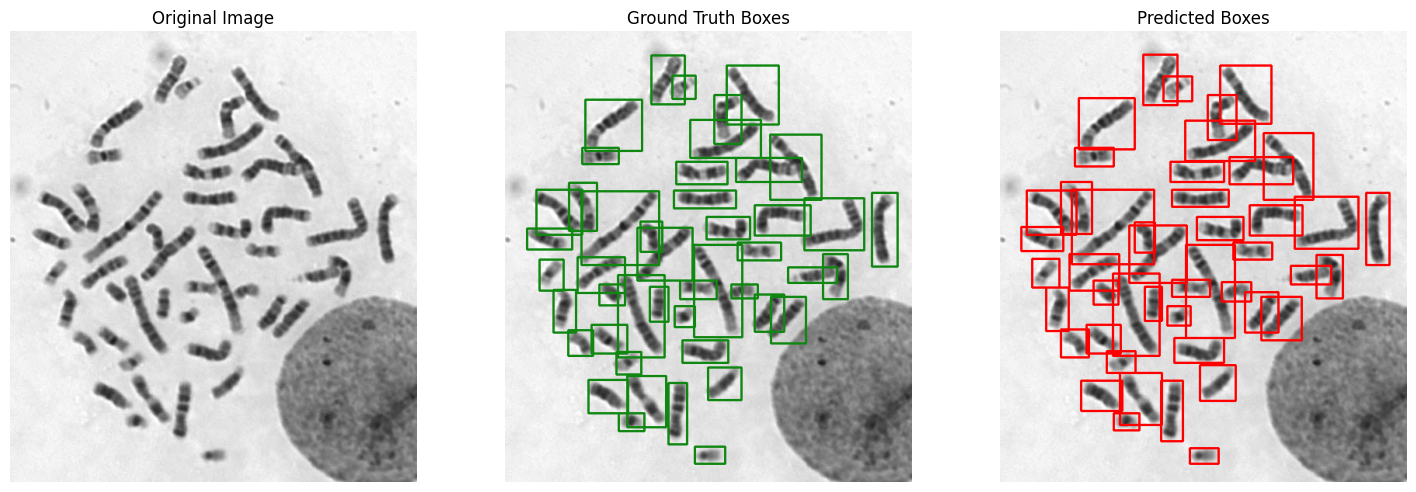

In [8]:
image_path  = "/content/Data/single_chromosomes_object/JEPG/103064.jpg"
labels_path = "/content/Data/single_chromosomes_object/anntations/103064.xml"
model_path  = "/content/Data/single_chromosomes_object/runs/yolo_chromosomes_n/weights/best.pt"

def parse_voc_annotations(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bboxes = []
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(float(bndbox.find('xmin').text))
        ymin = int(float(bndbox.find('ymin').text))
        xmax = int(float(bndbox.find('xmax').text))
        ymax = int(float(bndbox.find('ymax').text))
        bboxes.append([xmin, ymin, xmax, ymax])
    return bboxes

def draw_boxes(image, bboxes, color, thickness=2):
    for (xmin, ymin, xmax, ymax) in bboxes:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, thickness)

original_img = cv2.imread(image_path)

original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

gt_bboxes = parse_voc_annotations(labels_path)

gt_img = original_img.copy()
draw_boxes(gt_img, gt_bboxes, (17, 135, 15))
gt_rgb = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)

model = YOLO(model_path)
results = model(image_path)

pred_img = original_img.copy()

for r in results:
    for box in r.boxes:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
        cv2.rectangle(pred_img, (x1, y1), (x2, y2), (0,0,255), 2)

pred_rgb = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(original_rgb)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(gt_rgb)
axs[1].set_title("Ground Truth Boxes")
axs[1].axis('off')

axs[2].imshow(pred_rgb)
axs[2].set_title("Predicted Boxes")
axs[2].axis('off')

plt.tight_layout()
plt.show()